# LVC GW Targets

Generate a target list of host galaxies given the 50% and 90% credible localization regions of a GW alert.

In [1]:
from astropy.io import fits

import healpy as hp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

## Read GW LALInference Map

Extract localization PDF for a GW event and plot it using the DESI footprint.

Data can be downloaded from the [LVC GraceDB public alert page](https://gracedb.ligo.org/).

In [2]:
fits_file = 'S200224ca_LALInference.fits.gz'

# Read metadata.
hdus = fits.open(fits_file)
header = hdus[1].header

# instruments = header['INSTRUME']
distmean = header['DISTMEAN']
diststd = header['DISTSTD']
origin = header['ORIGIN']
date = header['DATE']

gwmap = hp.read_map(fits_file)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# Compute GW quantiles.
levels = [0.50, 0.90]
lev_vals = compute_quantiles(levels, gwmap)
print(levels, lev_vals)

# Compute GW contours.
prob64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
prob64 = prob64/np.sum(prob64)
pixels = np.arange(prob64.size)
#sample_points = np.array(hp.pix2ang(nside,pixels)).T
theta_contour, phi_contour = compute_contours(levels, prob64)

[0.5, 0.9] [5.739633330429371e-05, 5.236019043722391e-06]


1024
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 45 deg 0.00'.


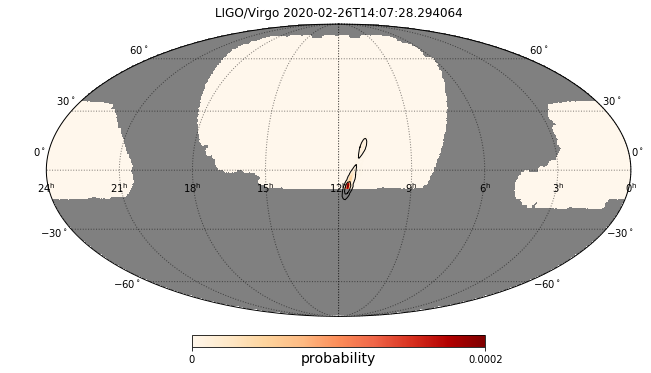

In [4]:
cmap = mpl.cm.OrRd
cmap.set_under('w')

# Access DESI contours.
nside = hp.pixelfunc.get_nside(gwmap)
print(nside)

desi_mask = hp.read_map('desi_mask_nside{:04d}.fits'.format(nside))
probs = np.copy(gwmap)
probs[desi_mask == 0] = hp.UNSEEN

hp.mollview(probs, cbar=True, unit=r'probability', title='{} {}'.format(origin, date),
            min=0, max=2e-4, flip='astro', rot=180, cmap=cmap)
hp.graticule(ls=':', alpha=0.5, dpar=30, dmer=45)

thmin, thmax = 1e99, -1e99
phmin, phmax = 1e99, -1e99
for i, (tc, pc) in enumerate(zip(theta_contour, phi_contour)):
    thmin = np.minimum(thmin, np.min(tc))
    thmax = np.maximum(thmax, np.max(tc))
    phmin = np.minimum(phmin, np.min(pc))
    phmax = np.maximum(phmax, np.max(pc))
    hp.projplot(tc, pc, linewidth=1, c='k')

ramin, ramax = np.degrees(phmin), np.degrees(phmax)
decmin, decmax = 90-np.degrees(thmax), 90-np.degrees(thmin)

ax = plt.gca()

# Label latitude lines.
ax.text( 2.00,  0.10, r'$0^\circ$', horizontalalignment='left')
ax.text( 1.80,  0.45, r'$30^\circ$', horizontalalignment='left')
ax.text( 1.30,  0.80, r'$60^\circ$', horizontalalignment='left')
ax.text( 1.83, -0.45, r'$-30^\circ$', horizontalalignment='left')
ax.text( 1.33, -0.80, r'$-60^\circ$', horizontalalignment='left')
ax.text(-2.00,  0.10, r'$0^\circ$', horizontalalignment='right')
ax.text(-1.80,  0.45, r'$30^\circ$', horizontalalignment='right')
ax.text(-1.30,  0.80, r'$60^\circ$', horizontalalignment='right')
ax.text(-1.85, -0.45, r'$-30^\circ$', horizontalalignment='right')
ax.text(-1.35, -0.80, r'$-60^\circ$', horizontalalignment='right')

# Label longitude lines.
ax.text( 2.0, -0.15, r'0$^\mathrm{h}$', horizontalalignment='center')
ax.text( 1.5, -0.15, r'3$^\mathrm{h}$', horizontalalignment='center')
ax.text( 1.0, -0.15, r'6$^\mathrm{h}$', horizontalalignment='center')
ax.text( 0.5, -0.15, r'9$^\mathrm{h}$', horizontalalignment='center')
ax.text( 0.0, -0.15, r'12$^\mathrm{h}$', horizontalalignment='center')
ax.text(-0.5, -0.15, r'15$^\mathrm{h}$', horizontalalignment='center')
ax.text(-1.0, -0.15, r'18$^\mathrm{h}$', horizontalalignment='center')
ax.text(-1.5, -0.15, r'21$^\mathrm{h}$', horizontalalignment='center')
ax.text(-2.0, -0.15, r'24$^\mathrm{h}$', horizontalalignment='center');

fig = plt.gcf()
fig.savefig('gw_skymap.png', dpi=100)

In [5]:
maxpix = np.argmax(gwmap)
ra, dec = hp.pix2ang(nside, maxpix, lonlat=True)
ra, dec

(173.8916015625, -8.084013907099305)

## Load DR8 Targets

Using the code from the [DESI target example notebook](https://github.com/qmxp55/desi_uk_meeting_2019/blob/master/desitarget_local_example.ipynb) created by Omar Macias, extract the targets within a box surrounding the 90% C.I.

In [6]:
# Load sample of resolve DR8 target catalogue
hpdirname = '/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright'

# Read targets in an RA, Dec, radius (degrees) "circle".
# radecrad = [ra ,dec,15]
# captargs = read_targets_in_cap(hpdirname, radecrad)
radecbox = [ramin, ramax, decmin, decmax]
captargs = read_targets_in_box(hpdirname, radecbox)

print('# rows = %i' %(len(captargs)))
print('# cols = %i' %(len(captargs.dtype.names)))

INFO:io.py:1828:read_target_files: Read 2490257 targets from targets-dr8-hp-8.fits, extension TARGETS...Took 0.8s
INFO:io.py:1828:read_target_files: Read 1932469 targets from targets-dr8-hp-26.fits, extension TARGETS...Took 0.6s
INFO:io.py:1828:read_target_files: Read 282863 targets from targets-dr8-hp-24.fits, extension TARGETS...Took 0.1s
INFO:io.py:1828:read_target_files: Read 1926328 targets from targets-dr8-hp-27.fits, extension TARGETS...Took 0.6s
# rows = 953885
# cols = 105


### Select Targets

Identify targets within the 50% and 90% contours, and apply a basic cut on bright BGS objects.

In [7]:
cappix = hp.ang2pix(nside, captargs['RA'], captargs['DEC'], lonlat=True)
is50 = gwmap[cappix] > lev_vals[0]
is90 = gwmap[cappix] > lev_vals[1]

bgs_bright = (captargs['BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0

In [8]:
select50 = np.logical_and(is50, bgs_bright)
ra50, dec50 = [captargs[_][select50] for _ in ['RA', 'DEC']]

select90 = np.logical_and(is90, bgs_bright)
ra90, dec90 = [captargs[_][select90] for _ in ['RA', 'DEC']]

rmag = 22.5 - 2.5*np.log10(captargs['FLUX_R'][select90])
rthr = np.max(rmag)

print('{:8d} targets in 50% C.I. with rmag > {:g}'.format(len(ra50), rthr))
print('{:8d} targets in 90% C.I. with rmag > {:g}'.format(len(ra90), rthr))

    7346 targets in 50% C.I. with rmag > 19.6947
   60410 targets in 90% C.I. with rmag > 19.6947


### Plot the Targets

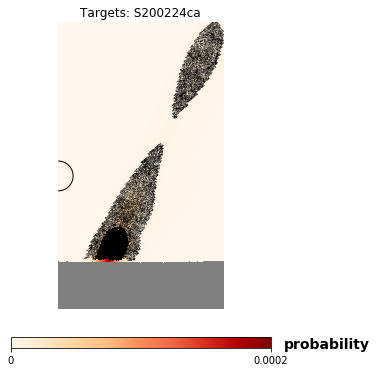

In [9]:
hp.cartview(probs, cmap=cmap, lonra=[ramin, 180], latra=[decmin, decmax], min=0, max=2e-4,
            title='Targets: S200224ca', unit=r'probability', flip='astro')
hp.projplot(ra50, dec50, 'k,', lonlat=True);
hp.projplot(ra90, dec90, 'k,', alpha=0.1, lonlat=True);

# Add tile 70502
ra_c, dec_c = 180., -0.5
ra70502 = [ra_c + 1.6*np.cos(th) for th in np.linspace(0, 2*np.pi, 201)]
dec70502 = [dec_c + 1.6*np.sin(th) for th in np.linspace(0, 2*np.pi, 201)]
hp.projplot(ra70502, dec70502, 'k-', lw=1, lonlat=True)

fig = plt.gcf()
fig.savefig('targlist.png', dpi=150)